## PyTorch examples
http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from time import time

### 1.) Loading and normalizing CIFAR10

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))   
    plt.show()

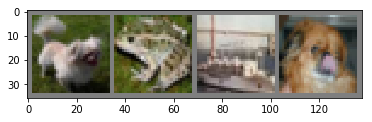

      dog      frog      ship       dog


In [7]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join("%9s" % classes[labels[j]] for j in range(4)))

### 2.) Define a convolutional neural network

In [8]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2) # pooling function the NN will use
        self.conv1 = nn.Conv2d(3, 6, 5)        
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Wouldn't it be better to be able to specify relu just once?
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5) # What is x.view ?
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # Why no activation function on the output?
        return x
    
net = Net()
print(net)

Net (
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)


### 3.) Define a loss function and optimizer

In [10]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

### 4.) Train the network

In [11]:
start = time()
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        if i==0 or i % 2000 == 1999:
            print("[%d, %5d] loss: %.3f" % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
            
print("Finished training.")            

[1,  2000] loss: 2.248
[1,  4000] loss: 1.886
[1,  6000] loss: 1.697
[1,  8000] loss: 1.584
[1, 10000] loss: 1.513
[1, 12000] loss: 1.469
[2,  2000] loss: 1.390
[2,  4000] loss: 1.361
[2,  6000] loss: 1.320
[2,  8000] loss: 1.298
[2, 10000] loss: 1.284
[2, 12000] loss: 1.257
Finished training.


### 5.) Test the network on the test data

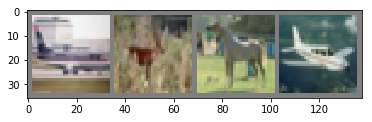

GroundTruth:     plane      deer     horse     plane
Predicted:       plane      deer     horse      ship


In [12]:
# dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth:", ' '.join('%9s' % classes[labels[j]] for j in range(4)))

outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print("Predicted:  ", " ".join("%9s" % classes[predicted[j]] for j in range(4)))

In [13]:
# Evaluate trained network on the test set
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [14]:
# Accuracy of individual classes
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 82 %
Accuracy of  bird : 51 %
Accuracy of   cat : 48 %
Accuracy of  deer : 42 %
Accuracy of   dog : 21 %
Accuracy of  frog : 62 %
Accuracy of horse : 62 %
Accuracy of  ship : 69 %
Accuracy of truck : 44 %


### 6.) Training on GPU

In [15]:
net.cuda()

Net (
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)

In [18]:
inputs, labels = inputs.cuda(), labels.cuda()

### 7.) Exercise: play with the size of the network
Can you increase (training?) speed while maintaining accuracy?

In [54]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.pool = nn.MaxPool2d(2, 2) # pooling function the NN will use
        self.conv1 = nn.Conv2d(3, 10, 5)        
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        # Wouldn't it be better to be able to specify relu just once?
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5) # What is x.view ?
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # Why no activation function on the output?
        return x
    
net = Net2()
print(net2)

Net2(
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv1): Conv2d (3, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d (30, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120)
  (fc2): Linear(in_features=120, out_features=84)
  (fc3): Linear(in_features=84, out_features=10)
)
